In [150]:
# %%capture
# !pip install pmdarima==1.8.0

In [151]:
import pandas as pd
import numpy as np

### Читаем данные

In [152]:
df=pd.read_csv('MaunaLoaDailyTemps.csv',index_col='DATE',parse_dates=True)
df=df.dropna()
print('Shape of data',df.shape)
print(df.columns)
df.head(7)

Shape of data (1821, 5)
Index(['MinTemp', 'MaxTemp', 'AvgTemp', 'Sunrise', 'Sunset'], dtype='object')


,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2014-01-01,33.0,46.0,40.0,657,1756
2014-01-02,35.0,50.0,43.0,657,1756
2014-01-03,36.0,45.0,41.0,657,1757
2014-01-04,32.0,41.0,37.0,658,1757
2014-01-05,24.0,38.0,31.0,658,1758
2014-01-06,22.0,39.0,31.0,658,1759
2014-01-07,28.0,45.0,37.0,658,1759


In [153]:
target_column = 'AvgTemp'

<AxesSubplot: xlabel='DATE'>

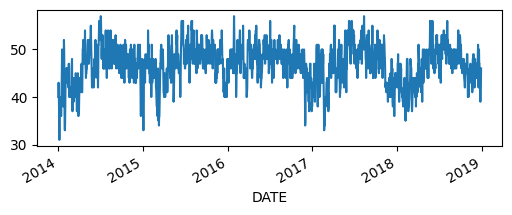

In [154]:
df[target_column].plot(figsize=(6,2))

### Тест на проверку стационарности

In [155]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [156]:
adf_test(df[target_column])

1. ADF :  -6.554680125068785
2. P-Value :  8.675937480199322e-09
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1808
5. Critical Values :
	 1% :  -3.433972018026501
	 5% :  -2.8631399192826676
	 10% :  -2.5676217442756872


### ARIMA(p,d,q) - подбираем параметры p,d,q

In [157]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [158]:
stepwise_fit = auto_arima(df[target_column], 
                          trace=True,
                          suppress_warnings=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8344.610, Time=2.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10347.755, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8365.701, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9136.225, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19192.139, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=8355.947, Time=1.84 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8356.308, Time=1.94 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=8347.221, Time=2.54 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=8317.212, Time=2.74 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=8330.189, Time=2.41 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=8310.657, Time=3.19 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=8332.297, Time=3.35 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=8317.488, Time=3.92 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=8304.972, Time=3.53 sec
 ARIMA(1,0,4)(0,0,0)[0] interce

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1821
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -4139.311
Date:                Wed, 18 Sep 2024   AIC                           8294.623
Time:                        12:02:22   BIC                           8338.680
Sample:                             0   HQIC                          8310.876
                               - 1821                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1474      0.345      3.326      0.001       0.471       1.824
ar.L1          0.9752      0.007    130.998      0.000       0.961       0.990
ma.L1         -0.1276      0.023     -5.461      0.000      -0.173      -0.082
ma.L2         -0.2238      0.024     -9.416      0.000      -0.270      -0.177
ma.L3         -0.2030      0.024     -8.597      0.000      -0.249      -0.157
ma.L4         -0.1395      0.023     -6.190      0.000      -0.184      -0.095
ma.L5         -0.0488      0.024     -2.020      0.043      -0.096      -0.001
sigma2         5.4499      0.169     32.237      0.000       5.119       5.781
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                19.89
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.17
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Теперь обучаем саму модельку с этими параметрами

In [159]:
train, test = df.iloc[:-30], df.iloc[-30:]
train.shape, test.shape

((1791, 5), (30, 5))

In [160]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train[target_column],order=(1,0,5))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                AvgTemp   No. Observations:                 1791
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -4070.198
Date:                Wed, 18 Sep 2024   AIC                           8156.395
Time:                        12:02:29   BIC                           8200.320
Sample:                             0   HQIC                          8172.614
                               - 1791                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.5856      0.758     61.454      0.000      45.100      48.071
ar.L1          0.9856      0.005    188.230      0.000       0.975       0.996
ma.L1         -0.1412      0.023     -6.124      0.000      -0.186      -0.096
ma.L2         -0.2268      0.024     -9.635      0.000      -0.273      -0.181
ma.L3         -0.2168      0.023     -9.251      0.000      -0.263      -0.171
ma.L4         -0.1479      0.023     -6.491      0.000      -0.193      -0.103
ma.L5         -0.0595      0.024     -2.438      0.015      -0.107      -0.012
sigma2         5.5093      0.174     31.624      0.000       5.168       5.851
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.88
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Посмотрим теперь, насколько хорошо моделька предсказывает

<AxesSubplot: xlabel='DATE'>

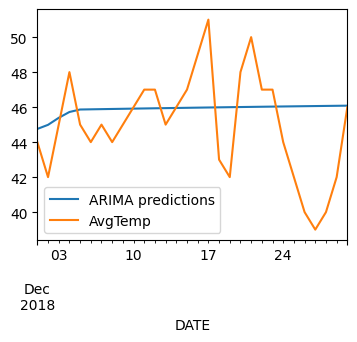

In [165]:
start=len(train)
end=len(train)+len(test)-1

pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred.index=pd.date_range(start='2018-12-01',end='2018-12-30')
pred.plot(legend=True, figsize=(4,3))
test[target_column].plot(legend=True)

### Еще один способ работы с ARIMA

In [166]:
import pmdarima as pm

model = pm.auto_arima(
    train[target_column], 
    seasonal=True, 
    m=1, 
    start_p=1,
    d=0,
    start_q=5,
    trace=True
)

# make your forecasts
forecasts = model.predict(test[target_column].shape[0])  # predict N steps into the future

Performing stepwise search to minimize aic
 ARIMA(1,0,5)(0,0,0)[0] intercept   : AIC=8158.866, Time=4.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10186.985, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8227.033, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8996.278, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18878.379, Time=0.02 sec
 ARIMA(0,0,5)(0,0,0)[0] intercept   : AIC=8281.287, Time=1.06 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=8160.358, Time=3.25 sec
 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=8165.007, Time=3.86 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=8318.207, Time=0.92 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=8172.053, Time=3.25 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=8168.744, Time=0.48 sec

Best model:  ARIMA(1,0,5)(0,0,0)[0] intercept
Total fit time: 17.388 seconds


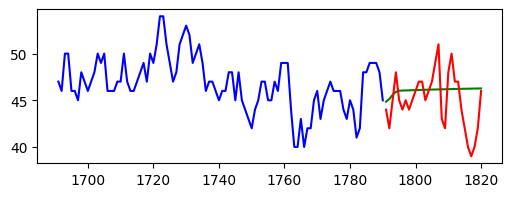

In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,2))
plt.plot(np.arange(train.shape[0])[-100:], train[target_column][-100:], c='blue')  # Обучающая выборка
plt.plot(np.arange(train.shape[0], train.shape[0] + test.shape[0]), forecasts, c='green') # ARIMA
plt.plot(np.arange(train.shape[0], train.shape[0] + test.shape[0]), test[target_column], c='red') # Так должно быть

### ARIMA хорошо предсказала среднее. Посмотрим дисперсию, чтобы понять, насколько наше последнее значение отклоняется от среднего

In [171]:
train[target_column].describe()

count    1791.000000
mean       46.849246
std         4.154374
min        31.000000
25%        44.000000
50%        47.000000
75%        50.000000
max        57.000000
Name: AvgTemp, dtype: float64

### Стандартное отклонение - 3.8 (Для tagret_column = MinTemp). А есть посмотреть std последнего кусочка?

In [172]:
train[target_column][-50:].describe()

count    50.000000
mean     45.280000
std       2.547828
min      40.000000
25%      44.000000
50%      45.000000
75%      47.000000
max      49.000000
Name: AvgTemp, dtype: float64

### Уже 2.9

### Есть еще метод Prophet, кторый представляет ряд в виде тренда, сезона, праздников и случайных колебаний

In [174]:
#!pip install prophet

In [175]:
from prophet import Prophet

In [176]:
train_prophet, test_prophet = df.iloc[:-30], df.iloc[-30:]
train_prophet = train_prophet.reset_index()
train_prophet.rename(columns={'DATE': 'ds', target_column: 'y'}, inplace=True)
train_prophet

,ds,MinTemp,MaxTemp,y,Sunrise,Sunset
0,2014-01-01,33.0,46.0,40.0,657,1756
1,2014-01-02,35.0,50.0,43.0,657,1756
2,2014-01-03,36.0,45.0,41.0,657,1757
3,2014-01-04,32.0,41.0,37.0,658,1757
4,2014-01-05,24.0,38.0,31.0,658,1758
...,...,...,...,...,...,...
1786,2018-11-26,41.0,56.0,49.0,637,1742
1787,2018-11-27,40.0,57.0,49.0,638,1742
1788,2018-11-28,42.0,56.0,49.0,638,1742
1789,2018-11-29,38.0,57.0,48.0,639,1742


In [177]:
model = Prophet()
model.fit(train_prophet)

12:06:43 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing


In [178]:
future = model.make_future_dataframe(periods=len(test_prophet))  # Прогноз на 7 дней вперед
forecast_prophet = model.predict(future)

             ds       yhat  yhat_lower  yhat_upper
0    2014-01-01  40.293391   36.150448   44.462767
1    2014-01-02  40.565932   36.381006   44.686378
2    2014-01-03  40.994630   36.708763   45.047012
3    2014-01-04  40.897533   36.583206   45.032286
4    2014-01-05  40.934184   36.621811   44.990859
...         ...        ...         ...         ...
1816 2018-12-26  41.464266   37.085992   45.790017
1817 2018-12-27  41.580163   37.370309   45.769917
1818 2018-12-28  41.865232   37.683082   46.185783
1819 2018-12-29  41.639744   37.507719   45.607185
1820 2018-12-30  41.565096   37.460359   45.945830

[1821 rows x 4 columns]


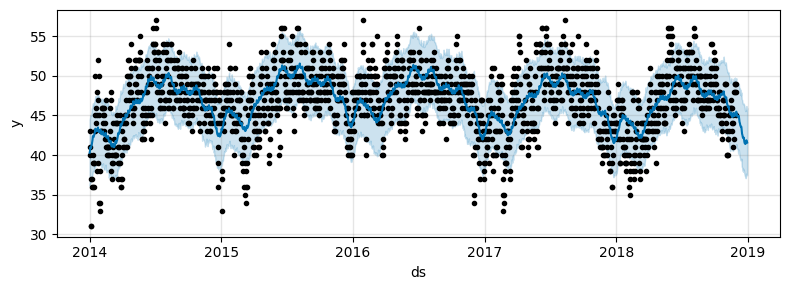

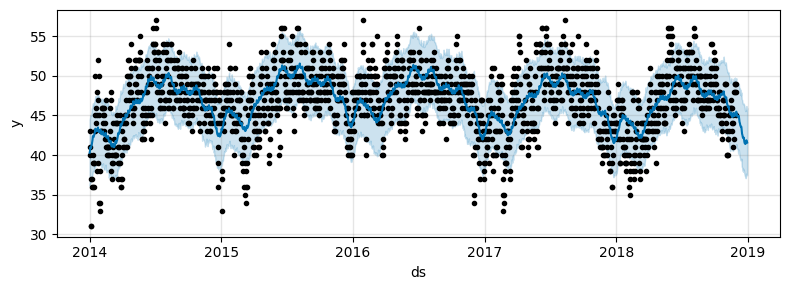

In [182]:
print(forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Визуализация прогноза
model.plot(forecast_prophet, figsize=(8,3))

### Есть еще Naive Forecaster - какими-то эвристиками орудует

### Есть Экспоненциальное сглаживание Хольта-Винтерса (Holt-Winters Exponential Smoothing) - де-факто - экспоненциальное сглаживание S_t = α⋅yt + (1−α)⋅S_{t−1}” с прогнозом, зависящее от тренда и сезонности


In [184]:
index = pd.date_range(start="2014-01-01", periods=len(df), freq='d')  # 'M' - месячная частота
df_indexed = pd.Series(df[target_column], index=index)
train_exp, test_exp = df_indexed.iloc[:-30], df_indexed.iloc[-30:]
train_exp = train_exp.interpolate()
train_exp.tail()

2018-11-22    41.0
2018-11-23    42.0
2018-11-24    48.0
2018-11-25    48.0
2018-11-26    49.0
Freq: D, Name: AvgTemp, dtype: float64

In [185]:
forecaster = ExponentialSmoothing(trend="add", seasonal="additive",sp=365)
forecaster.fit(train_exp)

ExponentialSmoothing(seasonal='additive', sp=365, trend='add')

In [186]:
pred_exp = forecaster.predict(fh=[x for x in range(1, 31)])

<AxesSubplot: >

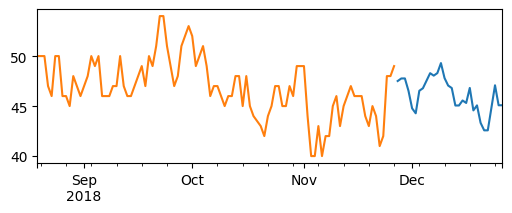

In [187]:
pred_exp.plot(figsize=(6,2))
train_exp.iloc[-100:].plot(figsize=(6,2))

# Сравнение методов

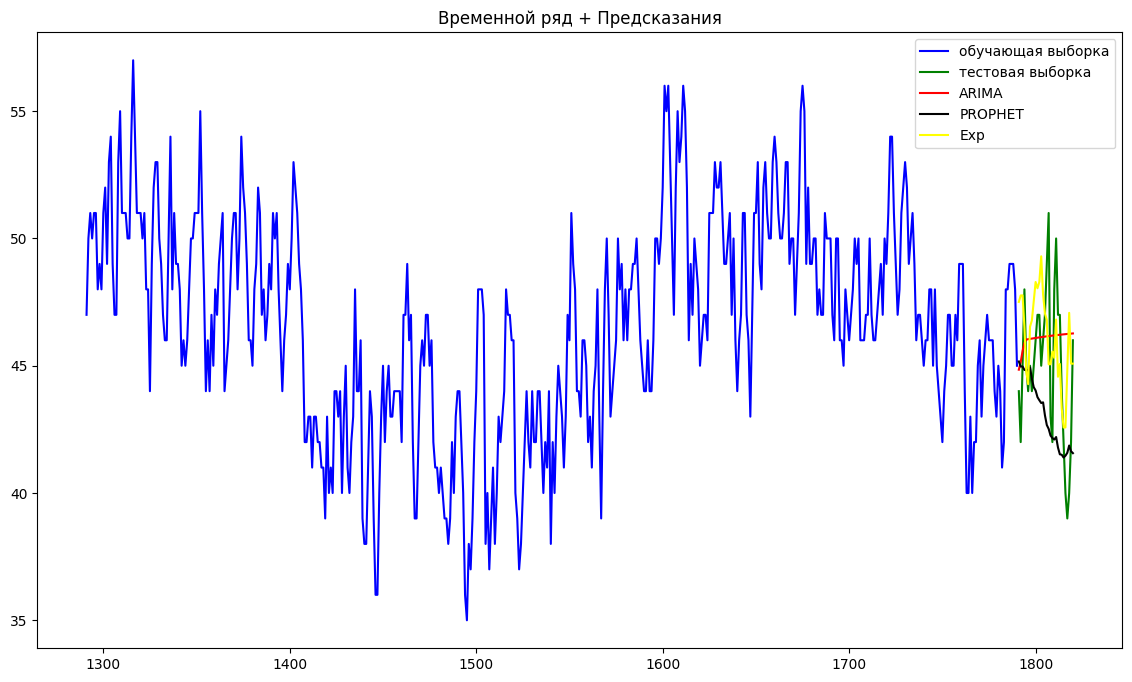

In [194]:
plt.figure(figsize=(14,8))
plt.plot(np.arange(train.shape[0])[-500:], train[target_column][-500:], c='blue', label='обучающая выборка')  # Обучающая выборка
plt.plot(np.arange(train.shape[0], train.shape[0] + test.shape[0]), test[target_column], c='green', label='тестовая выборка') # Так должно быть
plt.plot(np.arange(train.shape[0], train.shape[0] + test.shape[0]), forecasts, c='red', label='ARIMA') # ARIMA
plt.plot(np.arange(train.shape[0], train.shape[0] + test.shape[0]), forecast_prophet['yhat'].iloc[-len(test_prophet):], c='black', label='PROPHET') # PROPHET
plt.plot(np.arange(train.shape[0], train.shape[0] + test.shape[0]), pred_exp, c='yellow', label='Exp') # PROPHET
plt.title('Временной ряд + Предсказания')
plt.legend()

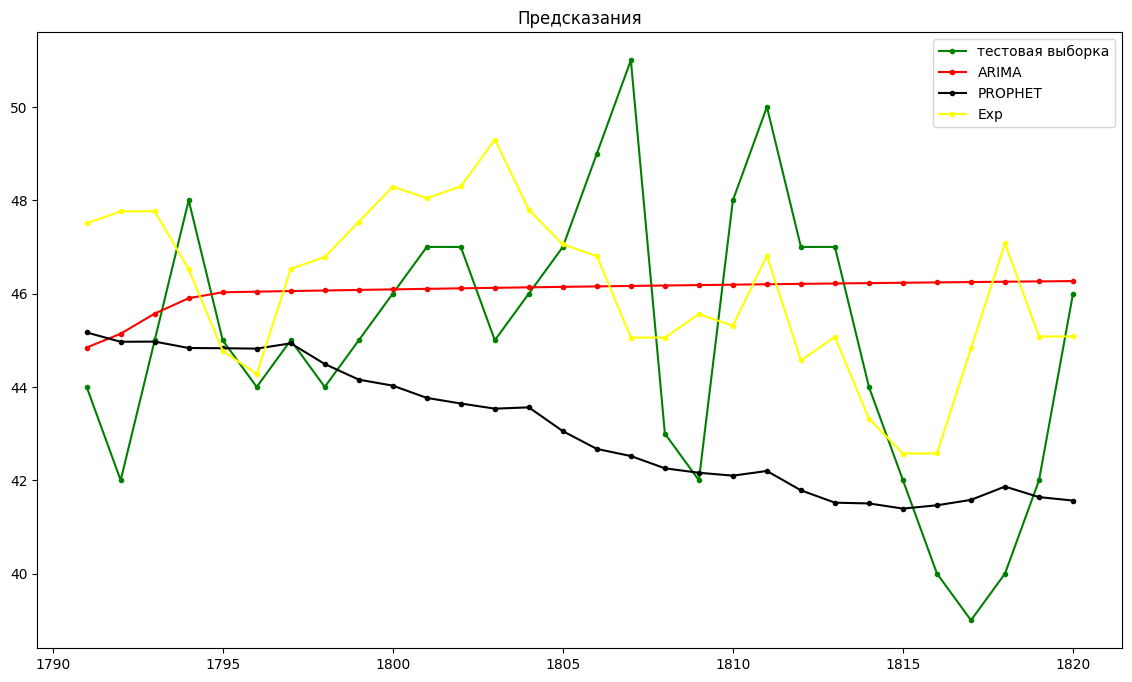

In [195]:
plt.figure(figsize=(14,8))
plt.plot(np.arange(train.shape[0], train.shape[0] + test.shape[0]), test[target_column], '.-', c='green', label='тестовая выборка') # Так должно быть
plt.plot(np.arange(train.shape[0], train.shape[0] + test.shape[0]), forecasts, '.-', c='red', label='ARIMA') # ARIMA
plt.plot(np.arange(train.shape[0], train.shape[0] + test.shape[0]), forecast_prophet['yhat'].iloc[-len(test_prophet):], '.-', c='black', label='PROPHET') # PROPHET
plt.plot(np.arange(train.shape[0], train.shape[0] + test.shape[0]), pred_exp, '.-', c='yellow', label='Exp') # PROPHET
plt.title('Предсказания')
plt.legend()

In [196]:
def mse_calc(s1, s2):
    return sum((s1-s2)**2)**0.5

def abs_diff(s1, s2):
    return sum(abs(s1-s2))

In [197]:
print('ARIMA MSE: ', mse_calc(test[target_column], forecasts))
print('PROPHET MSE: ', mse_calc(test[target_column], list(forecast_prophet['yhat'].iloc[-len(test_prophet):])))
print('EXP MSE: ', mse_calc(test[target_column], list(pred_exp)))
print()
print('ARIMA ABS: ', abs_diff(test[target_column], forecasts))
print('PROPHET ABS: ', abs_diff(test[target_column], list(forecast_prophet['yhat'].iloc[-len(test_prophet):])))
print('EXP ABS: ', abs_diff(test[target_column], list(pred_exp)))

ARIMA MSE:  16.744854868236438
PROPHET MSE:  19.371628651551653
EXP MSE:  16.957914162636065

ARIMA ABS:  70.86599021384286
PROPHET ABS:  80.05071546514662
EXP ABS:  76.37059633906804


# ИТОГИ

### ARIMA хорошо может работать со стационарными временными рядами и учитывать автокорреляцию (то есть зависимость новых значений от p предыдущих). Это в перую очередь полезно для краткосрочного прогнозирования в финансовых временных рядах, где нет как таковой сезонности, но есть сильная автокорреляция

### PROPHET хорошо учитывает сезонные истории - к примеру температура. Из последнего графика видно, что именно эта сезонность и учтена, но поять же - в трендовом смысле. То есть сильных колебаний у Prophet-а нет

### Exp Smoozing хорошо работает с сезонностью - на отрезке в 30 дней рост предсказывается ростом, а падения - падениями